In [1]:
import control
import numpy as np
import numpy.linalg as LA

In [3]:
g = 9.81
mass = 0.030
Ixx = 1.43e-5
Iyy = 1.43e-5
Izz = 2.89e-5
Ac = np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, g, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, (-g), 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ])
Bc = np.array([[0, 0, 0, 0],
                [0, 0, 0, 0],
                [0, 0, 0, 0],
                [0, 0, 0, 0],
                [0, 0, 0, 0],
                [1/mass, 0, 0, 0],
                [0, 0, 0, 0],
                [0, 0, 0, 0],
                [0, 0, 0, 0],
                [0, 1/Ixx, 0, 0],
                [0, 0, 1/Iyy, 0],
                [0, 0, 0, 1/Izz]])

C_obs = np.zeros((12, 12))
C_obs[:3, :3] = np.eye(3)
C_obs[6:9, 6:9] = np.eye(3)

Cc = C_obs
Dc = np.zeros((12, 4))
sysc = control.ss(Ac, Bc, Cc, Dc)
# Discretization
dt = 0.02
sysd = control.sample_system(sysc, dt, method='bilinear')
Ad, Bd, Cd =  sysd.A, sysd.B, sysd.C

In [4]:
class Dist_Observer:
    def __init__(self, A, B, B_dist, C=np.eye(12), C_dist=np.zeros((12, 3))):
        self.x_hat = np.zeros((12, 1))
        self.d_hat = np.zeros((3, 1))
        self.A_sq = np.block([[A, B_dist],
                              [np.zeros((3, 12)), np.eye(3)]])
        self.B_sq = np.block([[B],
                              [np.zeros((3, 4))]])
        self.C_sq = np.block([C, C_dist])
        eig = [0.5, 0.4, 0.3, -0.2, 0.5, 0.4, 0.3, -0.2, 0.5, 0.4, 0.3, -0.2, 0.3, 0.7, -0.5]
        # ctrb_matrix = control.obsv(self.A_sq, self.C_sq)
        # print(ctrb_matrix.shape)
        # print(LA.matrix_rank(ctrb_matrix))
        
        self.L = control.place(self.A_sq.T, self.C_sq.T, eig).T

    def update(self, u, y):
        exd_state = np.block([[self.x_hat],
                              [self.d_hat]])
        exd_state = self.A_sq@exd_state + \
            self.B_sq@u.reshape(-1, 1) + \
            self.L@(y.reshape(-1, 1) - self.C_sq@exd_state)
        self.x_hat = exd_state[:12]
        self.d_hat = exd_state[12:]
        


In [5]:
B_dist = np.block([[np.zeros((3, 3))],
                   [np.eye(3)],
                   [np.zeros((3, 3))],
                   [np.zeros((3, 3))]])

# vel_observer = Dist_Observer(Ad, Bd, B_dist, Cd)


In [6]:
import scipy.io

file_path = 'saveL.mat'
mat = scipy.io.loadmat(file_path)
data = mat['L']

In [4]:
0.2*9.81*0.02


0.039240000000000004

In [6]:
import csv
file = open("data.csv", "r")
csvreader = csv.reader(file)
rows = [row for row in csvreader]


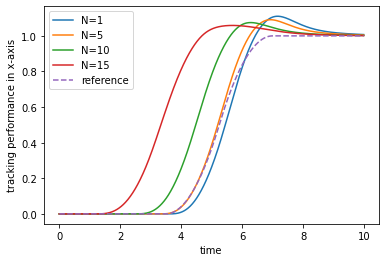

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv('data.csv', header=None)
data = data.T
N1_real = data.iloc[:, 0].to_list()
N1_des = data.iloc[:, 1].to_list()
N5_real = data.iloc[:, 2].to_list()
N10_real = data.iloc[:, 4].to_list()
N15_real = data.iloc[:, 6].to_list()
t = np.arange(0, 10, 0.01)

plt.plot(t, N1_real, label="N=1")
plt.plot(t, N5_real, label="N=5")
plt.plot(t, N10_real, label="N=10")
# plt.plot(t, N10_des, label="N10_des")
plt.plot(t, N15_real, label="N=15")
# plt.plot(t, N15_des, label="N15_des")
plt.plot(t, N1_des, '--', label="reference")

plt.xlabel('time')
plt.ylabel('tracking performance in x-axis')
plt.legend()
plt.show()